In [115]:
# Autors - Peleg Biton 203842703 & Omer Nagar 307937714 
from anytree import AnyNode, RenderTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
nodes_generated, nodes_expanded = 0, 0
colors = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']
dir_path =  r'C:/Users/pbiton/OneDrive - Intel Corporation/Desktop/input_data/'
input_path = dir_path +'felner_exp_sum=24.xlsx'
output_path = dir_path + 'felner_exp_sum=24_output.csv'
inputs_df = pd.read_excel(input_path)
output_cols_list = ['branching_factor', 'n_players', 'n_rounds', 'max_depth', 'max_sum', 'epsilon', 'shallow_er', 'bounded_er', 'opt_score', 'sub_opt_score', 'different']

In [103]:
def generate_all3_vector_values( max_sum) : 
    all_vectors=[]
    for i in range(max_sum+1):
        for j in range(max_sum+1):
            for k in range(max_sum+1):
                if i+j+k==max_sum:
                    vector=[i,j,k]
                    all_vectors.append(vector)
    return all_vectors
def generate_all4_vector_values( max_sum) : 
    all_vectors=[]
    for i in range(max_sum+1):
        for j in range(max_sum+1):
            for k in range(max_sum+1):
                for l in range(max_sum+1):
                    if i+j+k+l==max_sum:
                        vector=[i,j,k,l]
                        all_vectors.append(vector)
    return all_vectors
all3_vectors = generate_all3_vector_values(12)
all4_vectors = generate_all4_vector_values(12)

In [104]:
def generate_vector_values(max_sum, all_vectors):
    rand_index = random.randint(0, len(all_vectors)-1)
    return all_vectors[rand_index]
    
def generate_random_leave(name, n_players, max_sum, parent, depth):
    global nodes_generated, all3_vectors, all4_vectors
    if n_players==3:
        value = generate_vector_values(max_sum, all3_vectors)
    else:
        value = generate_vector_values(max_sum, all4_vectors)
    node = AnyNode(id=name, parent=parent, depth=depth, turn=depth%n_players, value=value, max_sum=max_sum)
    nodes_generated+=1
    return node


def generate_node(name, n_players, parent, depth):
    global nodes_generated
    value = np.array([0]*n_players)
    node = AnyNode(id=name, parent=parent, depth=depth, turn=depth%n_players, value=value, max_sum=max_sum)
    nodes_generated+=1
    return node


def generate_nodes_floor(branching_factor, n_players, max_sum, parent, max_depth, depth):
    for i in range(branching_factor):
        node_name = "d{}_b{}".format(depth, i)
        if depth==max_depth:
            leave = generate_random_leave(node_name, n_players, max_sum, parent, depth)
        else:
            node = generate_node(node_name, n_players, parent, depth)
            generate_nodes_floor(branching_factor, n_players, max_sum, node, max_depth, depth+1)
        
def generate_tree():
    global nodes_generated, branching_factor, n_players, max_sum, max_depth
    root = AnyNode(id="root", depth=0, turn=0, value =[0]*n_players)
    nodes_generated+=1
    generate_nodes_floor(branching_factor, n_players, max_sum, root, max_depth, 1)
    return root


def Expanding_Rate(algo):
    global nodes_expanded, nodes_generated
    er = nodes_expanded/nodes_generated
    nodes_expanded = 0
    return er


# def Choose_Move(node, player):
#     for child in node.children:
#         if np.array_equal(child.value, node.value):
#             return child

# def Simulate_3Players_Game(root):
#     global max_sum, epsilon
#     curr=root
#     while len(curr.children)>0:
#         print(curr.turn)
#         if curr.turn == 0:
#             chosen_node, chosen_index = Bounded_Pruning(curr, max_sum, epsilon)
#         elif curr.turn == 1:
#             chosen_node, chosen_index = Shallow(curr, max_sum)
#         else:
#             chosen_node, chosen_index= MaxN(curr, max_sum)
#         curr = curr.children[chosen_index]
#     return curr.value

In [105]:
def Bounded_Pruning(node, bound, epsilon):
    global nodes_expanded, max_sum, promised, n_players
    nodes_expanded += 1
    if len(node.children) == 0:
        #print('node.value: ',node.value)
        return node.value
    b_best = Bounded_Pruning(node.children[0], max_sum, epsilon)
    for child in range(1, len(node.children)):
        if node.id == 'root':
            promised = max(promised, b_best[0])
            if promised + epsilon >= max_sum:
                #node.value = b_best
                return b_best
        if node.turn == 1 and promised + epsilon >= max_sum - b_best[node.turn]:
            return np.array([0]*n_players)
        if (b_best[node.turn] >= bound):
            return b_best
        current = Bounded_Pruning(node.children[child], max_sum-b_best[node.turn], epsilon)
        if current[node.turn] > b_best[node.turn]:
            b_best = current
    return b_best

In [106]:
def Shallow(node, bound):
    global nodes_expanded, max_sum, n_players
    nodes_expanded += 1
    if len(node.children) == 0:
        return node.value
    best = Shallow(node.children[0], max_sum)
    for child in range(1, len(node.children)):
        if best[node.turn]>=bound:
            return best
        current = Shallow(node.children[child], max_sum- best[node.turn])
        if current[node.turn] > best[node.turn]:
            best = current
    return best
def MaxN(node, bound):
    global nodes_expanded, max_sum, n_players
    nodes_expanded += 1
    if len(node.children) == 0:
        return node.value
    best = MaxN(node.children[0], max_sum)
    for child in range(1, len(node.children)):
        current = MaxN(node.children[child], max_sum- best[node.turn])
        if current[node.turn] > best[node.turn]:
            best = current
    return best

In [107]:
def simulate_expanding_rate():
    global max_sum, epsilon
    root = generate_tree()
    Bounded_result = Bounded_Pruning(root, max_sum, epsilon)
    Bounded_er = Expanding_Rate('Bounded')
    Shallow_result = Shallow(root, max_sum)
    Shallow_er = Expanding_Rate('Shallow')
    MaxN_result = MaxN(root, max_sum)
    MaxN_er = Expanding_Rate('MaxN')
    return root, Bounded_result, Bounded_er, Shallow_result, Shallow_er, MaxN_result, MaxN_er

In [108]:
def simulate_n_exp(n):
    global nodes_generated, nodes_expanded, promised
    Bounded_ers=0
    Shallow_ers=0
    MaxN_ers=0
    for i in range(n):
        nodes_generated, nodes_expanded, promised = 0, 0, 0
        root, Bounded_result, Bounded_er, Shallow_result, Shallow_er, MaxN_result, MaxN_er = simulate_expanding_rate()
        Bounded_ers+=Bounded_er
        Shallow_ers+=Shallow_er
        MaxN_ers+=MaxN_er
    return Bounded_ers/n, Bounded_result, Shallow_ers/n, Shallow_result, MaxN_ers/n, MaxN_result
output_df = pd.DataFrame(columns=output_cols_list)

In [129]:
def plot_scatter(df, epsilons):
    global colors
    fig, axs = plt.subplots(3, figsize=(15,25))
    fig.suptitle('er vs branching_factor', fontsize=20)
    df1 = df.query('epsilon=={}'.format(epsilons[0]))
    df2 = df.query('epsilon=={}'.format(epsilons[1])) 
    df3 = df.query('epsilon=={}'.format(epsilons[2])) 
    
    for i in range(6,10):
        query = 'max_depth=={}'.format(i)
        label_o = "max depth={} algo=bounded".format(i)
        label_x = "max depth={} algo=shallow".format(i)
        color = colors[i-6]
        
        temp1 = df1.query(query)
        x = temp1['branching_factor']
        y_bound = temp1['bounded_er']
        y_shallow = temp1['shallow_er']
        axs[0].scatter(x, y_bound, marker='o', c=[color]*len(x), label=label_o)
        axs[0].scatter(x, y_shallow, marker='x', c=[color]*len(x), label=label_x)
        
        temp2 = df2.query(query)
        x = temp2['branching_factor']
        y_bound = temp2['bounded_er']
        y_shallow = temp2['shallow_er']
        axs[1].scatter(x, y_bound, marker='o', c=[color]*len(x), label=label_o)
        axs[1].scatter(x, y_shallow, marker='x', c=[color]*len(x), label=label_x)
        
        temp3 = df3.query(query)
        x = temp3['branching_factor']
        y_bound = temp3['bounded_er']
        y_shallow = temp3['shallow_er']
        axs[2].scatter(x, y_bound, marker='o', c=[color]*len(x), label=label_o)
        axs[2].scatter(x, y_shallow, marker='x', c=[color]*len(x), label=label_x)
        
    bounded_er_means1 = []
    shallow_er_means1 = []
    bounded_er_means2 = []
    shallow_er_means2 = []
    bounded_er_means3 = []
    shallow_er_means3 = []
    x=np.arange(2,7)
    for i in range(2,7):
        query = 'branching_factor=={}'.format(i)
        temp1 = df1.query(query)
        temp2 = df2.query(query)
        temp3 = df3.query(query)
        bounded_er_means1.append(np.mean(temp1['bounded_er']))
        shallow_er_means1.append(np.mean(temp1['shallow_er']))
        bounded_er_means2.append(np.mean(temp2['bounded_er']))
        shallow_er_means2.append(np.mean(temp2['shallow_er']))
        bounded_er_means3.append(np.mean(temp3['bounded_er']))
        shallow_er_means3.append(np.mean(temp3['shallow_er']))
    
    axs[0].plot(x, bounded_er_means1, label='Mean bounded er', linestyle='--')
    axs[0].plot(x, shallow_er_means1, label='Mean shallow er', linestyle='-.')
    axs[0].set_title('epsilon={}'.format(epsilons[0]), fontsize=20)
    axs[0].set_xlabel('branching_factor', rotation=0, fontsize=15, labelpad=10)
    axs[0].set_ylabel('er', rotation=0, fontsize=15, labelpad=20)
    axs[0].set_ylim(0, 1.1)
    axs[0].legend(loc='upper right', bbox_to_anchor=(1.23, 1.015))
    
    axs[1].plot(x, bounded_er_means2, label='Mean bounded er', linestyle='--')
    axs[1].plot(x, shallow_er_means2, label='Mean shallow er', linestyle='-.')
    axs[1].set_title('epsilon={}'.format(epsilons[1]), fontsize=20)
    axs[1].set_xlabel('branching_factor', rotation=0, fontsize=15, labelpad=10)
    axs[1].set_ylabel('er', rotation=0, fontsize=15, labelpad=20)
    axs[1].set_ylim(0, 1.1)
    axs[1].legend(loc='upper right', bbox_to_anchor=(1.23, 1.015))
    
    axs[2].plot(x, bounded_er_means3, label='Mean bounded er', linestyle='--')
    axs[2].plot(x, shallow_er_means3, label='Mean shallow er', linestyle='-.')
    axs[2].set_title('epsilon={}'.format(epsilons[2]), fontsize=20)
    axs[2].set_xlabel('branching_factor', rotation=0, fontsize=15, labelpad=10)
    axs[2].set_ylabel('er', rotation=0, fontsize=15, labelpad=20)
    axs[2].set_ylim(0, 1.1)
    axs[2].legend(loc='upper right', bbox_to_anchor=(1.23, 1.015))
    plt.show()
def plot_scatter2(df, epsilons):
    global colors
    fig, axs = plt.subplots(3, figsize=(15,25))
    fig.suptitle('er vs max depth', fontsize=20)
    df1 = df.query('epsilon=={}'.format(epsilons[0]))
    df2 = df.query('epsilon=={}'.format(epsilons[1])) 
    df3 = df.query('epsilon=={}'.format(epsilons[2])) 
    for i in range(2,7):
        query = 'branching_factor=={}'.format(i)
        label_o = "branching_factor={} algo=bounded".format(i)
        label_x = "branching_factor={} algo=shallow".format(i)
        color = colors[i-2]
        
        temp1 = df1.query(query)
        x = temp1['max_depth']
        y_bound = temp1['bounded_er']
        y_shallow = temp1['shallow_er']
        axs[0].scatter(x, y_bound, marker='o', c=[color]*len(x), label=label_o)
        axs[0].scatter(x, y_shallow, marker='x', c=[color]*len(x), label=label_x)
        
        temp2 = df2.query(query)
        x = temp2['max_depth']
        y_bound = temp2['bounded_er']
        y_shallow = temp2['shallow_er']
        axs[1].scatter(x, y_bound, marker='o', c=[color]*len(x), label=label_o)
        axs[1].scatter(x, y_shallow, marker='x', c=[color]*len(x), label=label_x)
        
        temp3 = df3.query(query)
        x = temp3['max_depth']
        y_bound = temp3['bounded_er']
        y_shallow = temp3['shallow_er']
        axs[2].scatter(x, y_bound, marker='o', c=[color]*len(x), label=label_o)
        axs[2].scatter(x, y_shallow, marker='x', c=[color]*len(x), label=label_x)
        
    bounded_er_means1 = []
    shallow_er_means1 = []
    bounded_er_means2 = []
    shallow_er_means2 = []
    bounded_er_means3 = []
    shallow_er_means3 = []
    x=np.arange(6,10)
    for i in range(6,10):
        query = 'max_depth=={}'.format(i)
        temp1 = df1.query(query)
        temp2 = df2.query(query)
        temp3 = df3.query(query)
        bounded_er_means1.append(np.mean(temp1['bounded_er']))
        shallow_er_means1.append(np.mean(temp1['shallow_er']))
        bounded_er_means2.append(np.mean(temp2['bounded_er']))
        shallow_er_means2.append(np.mean(temp2['shallow_er']))
        bounded_er_means3.append(np.mean(temp3['bounded_er']))
        shallow_er_means3.append(np.mean(temp3['shallow_er']))
    
    axs[0].plot(x, bounded_er_means1, label='Mean bounded er', linestyle='--')
    axs[0].plot(x, shallow_er_means1, label='Mean shallow er', linestyle='-.')
    axs[0].set_title('epsilon={}'.format(epsilons[0]), fontsize=20)
    axs[0].set_xlabel('max_depth', rotation=0, fontsize=15, labelpad=10)
    axs[0].set_ylabel('er', rotation=0, fontsize=15, labelpad=20)
    axs[0].set_ylim(0, 1.1)
    axs[0].legend(loc='upper right', bbox_to_anchor=(1.23, 1.015))
    
    axs[1].plot(x, bounded_er_means2, label='Mean bounded er', linestyle='--')
    axs[1].plot(x, shallow_er_means2, label='Mean shallow er', linestyle='-.')
    axs[1].set_title('epsilon={}'.format(epsilons[1]), fontsize=20)
    axs[1].set_xlabel('max_depth', rotation=0, fontsize=15, labelpad=10)
    axs[1].set_ylabel('er', rotation=0, fontsize=15, labelpad=20)
    axs[1].set_ylim(0, 1.1)
    axs[1].legend(loc='upper right', bbox_to_anchor=(1.23, 1.015))
    
    axs[2].plot(x, bounded_er_means3, label='Mean bounded er', linestyle='--')
    axs[2].plot(x, shallow_er_means3, label='Mean shallow er', linestyle='-.')
    axs[2].set_title('epsilon={}'.format(epsilons[2]), fontsize=20)
    axs[2].set_xlabel('max_depth', rotation=0, fontsize=15, labelpad=10)
    axs[2].set_ylabel('er', rotation=0, fontsize=15, labelpad=20)
    axs[2].set_ylim(0, 1.1)
    axs[2].legend(loc='upper right', bbox_to_anchor=(1.23, 1.015))
    plt.show()

max sum =12

In [ ]:
random.seed(4)
for row in range(inputs_df.shape[0]):
    branching_factor = inputs_df['branching_factor'].iloc[row]
    n_players = inputs_df['n_players'].iloc[row]
    n_rounds = inputs_df['n_rounds'].iloc[row]
    max_depth = inputs_df['max_depth'].iloc[row]
    max_sum = inputs_df['max_sum'].iloc[row]
    epsilon = inputs_df['epsilon'].iloc[row]
    Bounded_er, Bounded_result, Shallow_er, Shallow_result, MaxN_er, MaxN_result = simulate_n_exp(1)
    output_line = pd.DataFrame([[branching_factor, n_players, n_rounds, max_depth, max_sum, epsilon, Shallow_er, Bounded_er, Shallow_result[0], Bounded_result[0], Shallow_result[0]- Bounded_result[0]]], columns=output_cols_list)
    output_df = pd.concat([output_df, output_line])
output_df.to_csv(output_path)

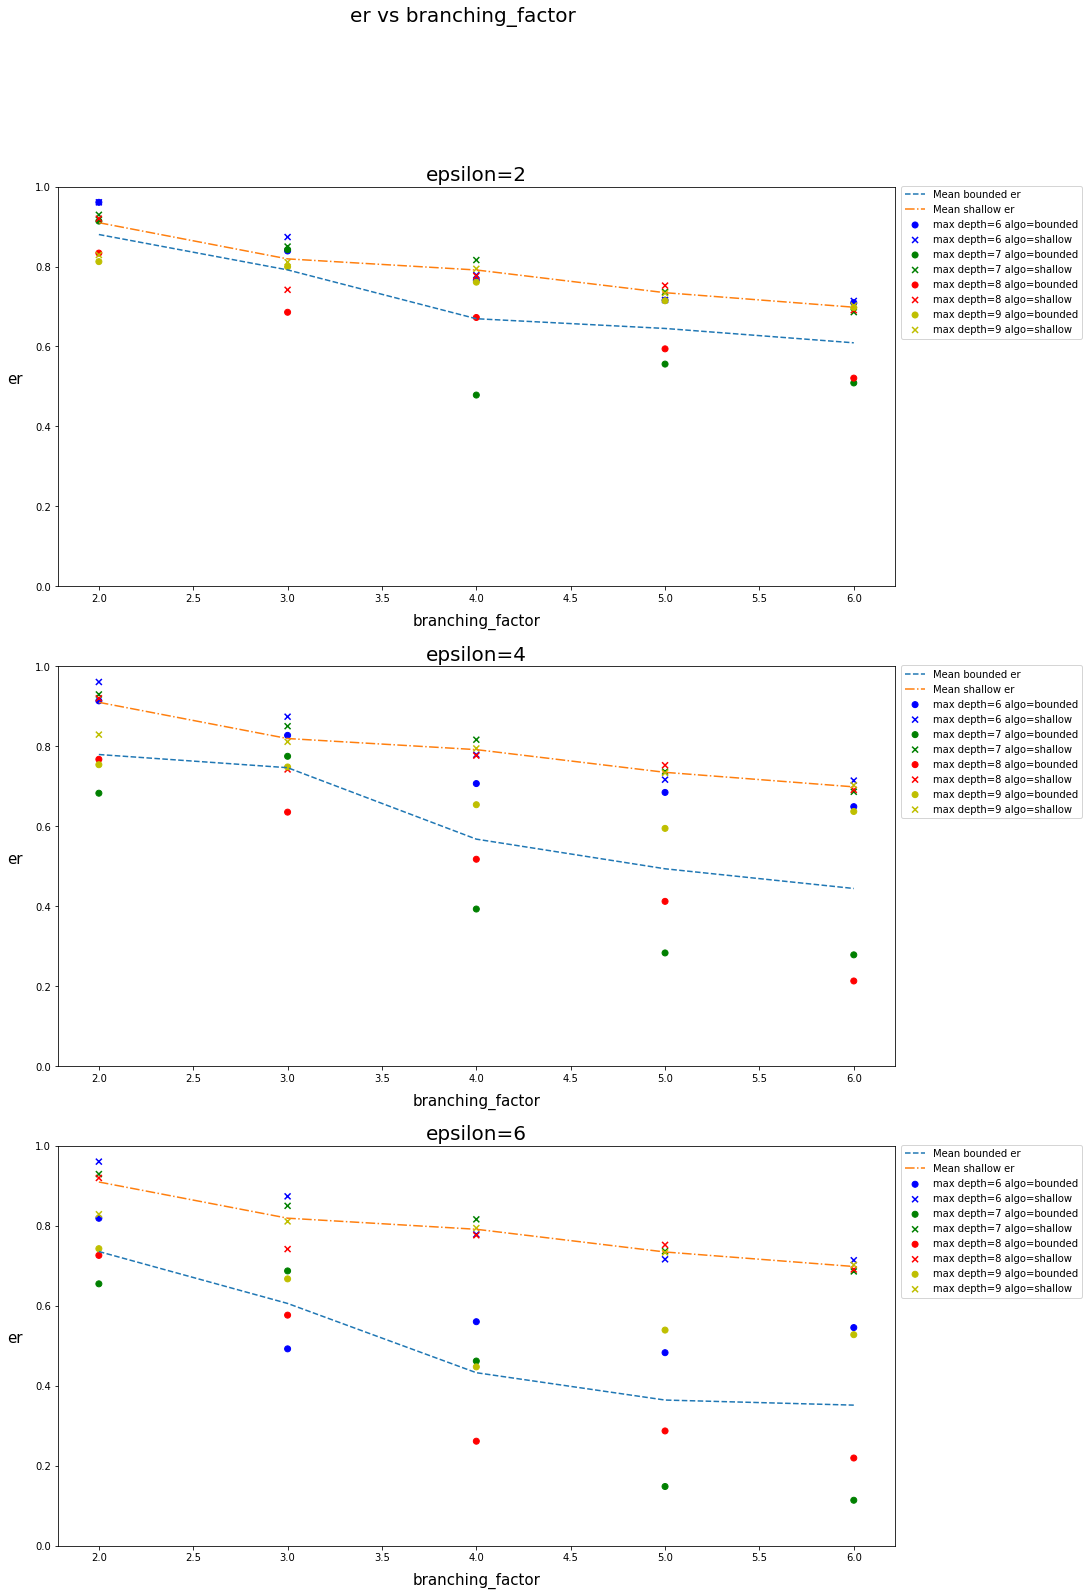

In [85]:
plot_scatter(output_df, output_df['epsilon'].unique())

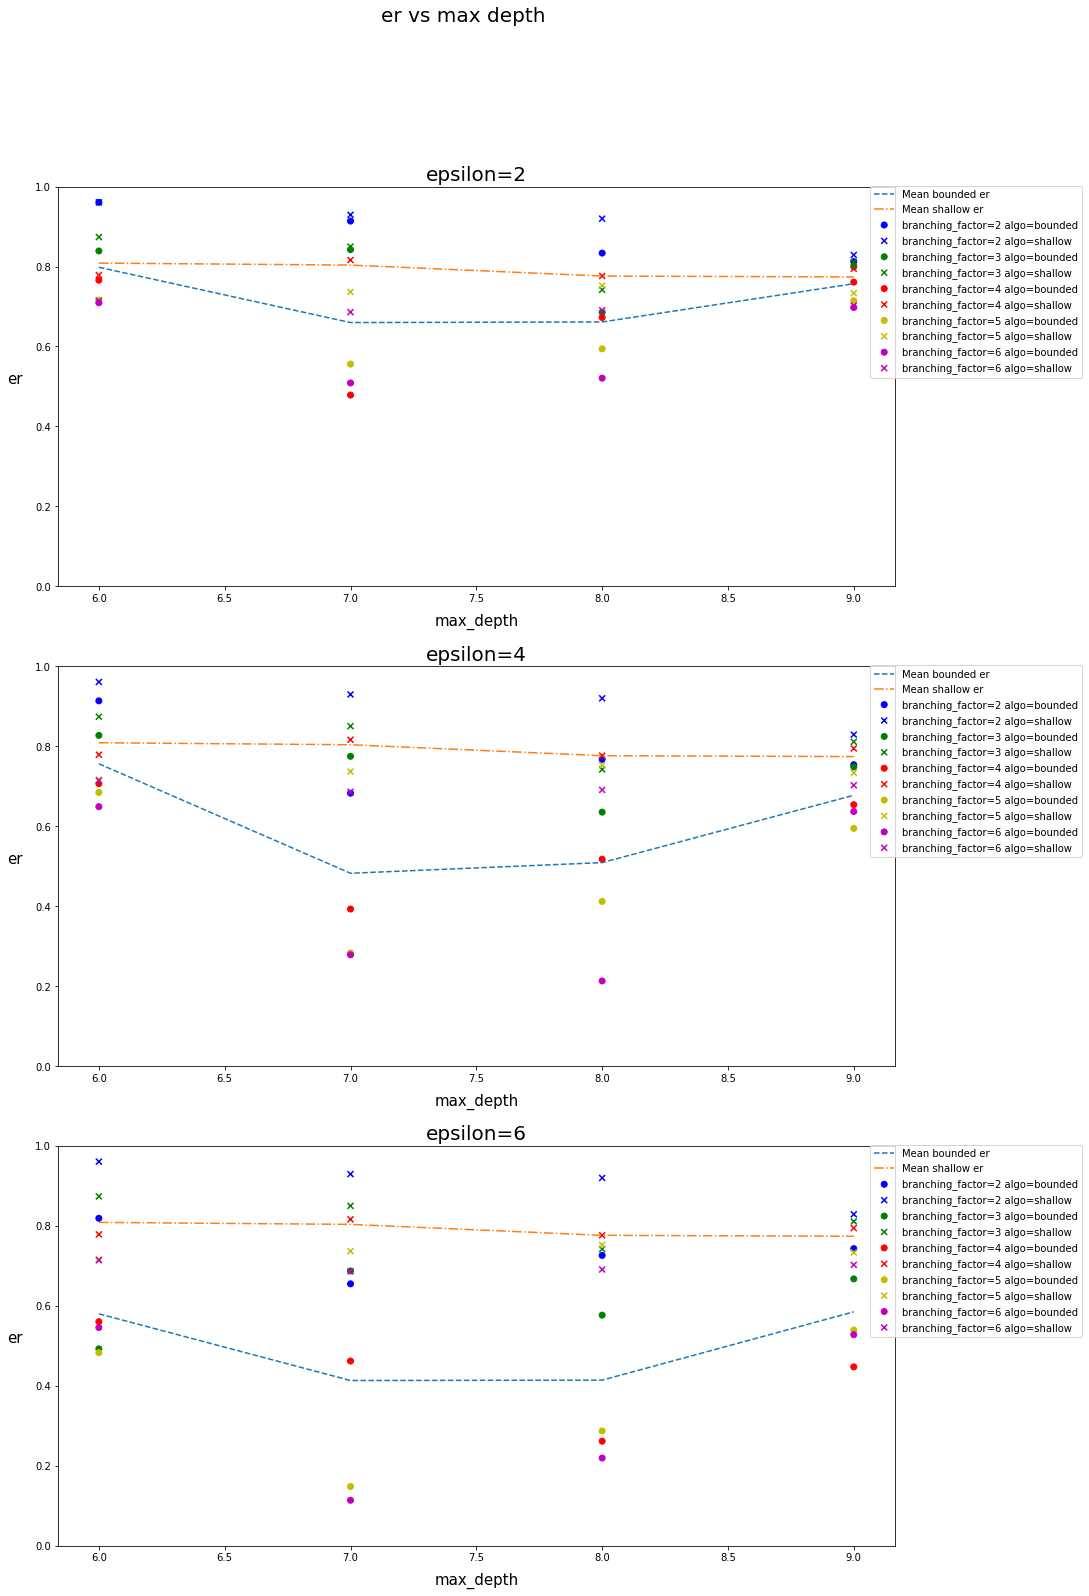

In [86]:
plot_scatter2(output_df, output_df['epsilon'].unique())

In [88]:
output_df[['branching_factor','n_players','max_depth','max_sum','epsilon','shallow_er','bounded_er']]

,branching_factor,n_players,max_depth,max_sum,epsilon,shallow_er,bounded_er
0,2,3,6,12,2,0.960630,0.960630
1,3,3,6,12,2,0.873742,0.838975
2,4,3,6,12,2,0.778612,0.765794
3,5,3,6,12,2,0.716246,0.715939
4,6,3,6,12,2,0.713898,0.709522
5,2,3,7,12,2,0.929412,0.913725
6,3,3,7,12,2,0.850000,0.842378
7,4,3,7,12,2,0.816205,0.478462
8,5,3,7,12,2,0.736555,0.555952
9,6,3,7,12,2,0.685949,0.508771


max sum =24

In [ ]:
random.seed(4)
for row in range(inputs_df.shape[0]):
    branching_factor = inputs_df['branching_factor'].iloc[row]
    n_players = inputs_df['n_players'].iloc[row]
    n_rounds = inputs_df['n_rounds'].iloc[row]
    max_depth = inputs_df['max_depth'].iloc[row]
    max_sum = inputs_df['max_sum'].iloc[row]
    epsilon = inputs_df['epsilon'].iloc[row]
    Bounded_er, Bounded_result, Shallow_er, Shallow_result, MaxN_er, MaxN_result = simulate_n_exp(1)
    output_line = pd.DataFrame([[branching_factor, n_players, n_rounds, max_depth, max_sum, epsilon, Shallow_er, Bounded_er, Shallow_result[0], Bounded_result[0], Shallow_result[0]- Bounded_result[0]]], columns=output_cols_list)
    output_df = pd.concat([output_df, output_line])
output_df.to_csv(output_path)

In [132]:
output_df[['branching_factor','n_players','max_depth','max_sum','epsilon','shallow_er','bounded_er']]

,branching_factor,n_players,max_depth,max_sum,epsilon,shallow_er,bounded_er
0,2,3,6,24,4,1.000000,1.000000
1,3,3,6,24,4,1.000000,1.000000
2,4,3,6,24,4,1.000000,1.000000
3,5,3,6,24,4,1.000000,1.000000
4,6,3,6,24,4,1.000000,1.000000
5,2,3,7,24,4,1.000000,1.000000
6,3,3,7,24,4,1.000000,1.000000
7,4,3,7,24,4,1.000000,1.000000
8,5,3,7,24,4,1.000000,1.000000
9,6,3,7,24,4,1.000000,1.000000


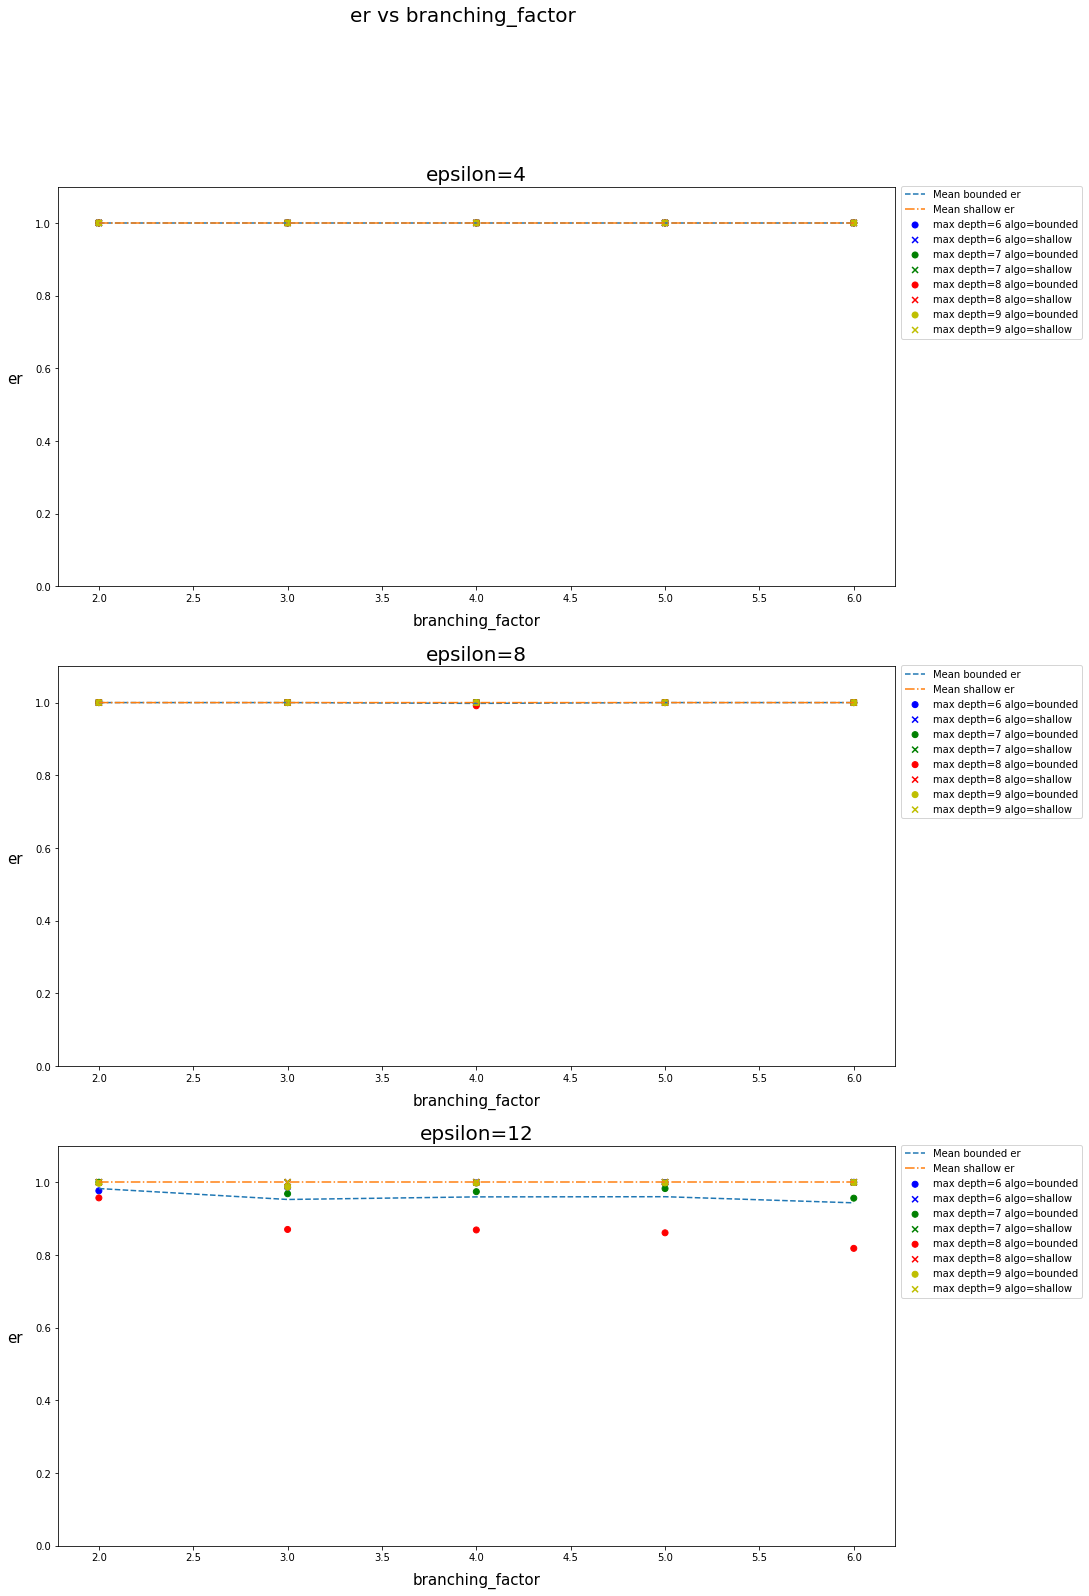

In [130]:
plot_scatter(output_df, output_df['epsilon'].unique())

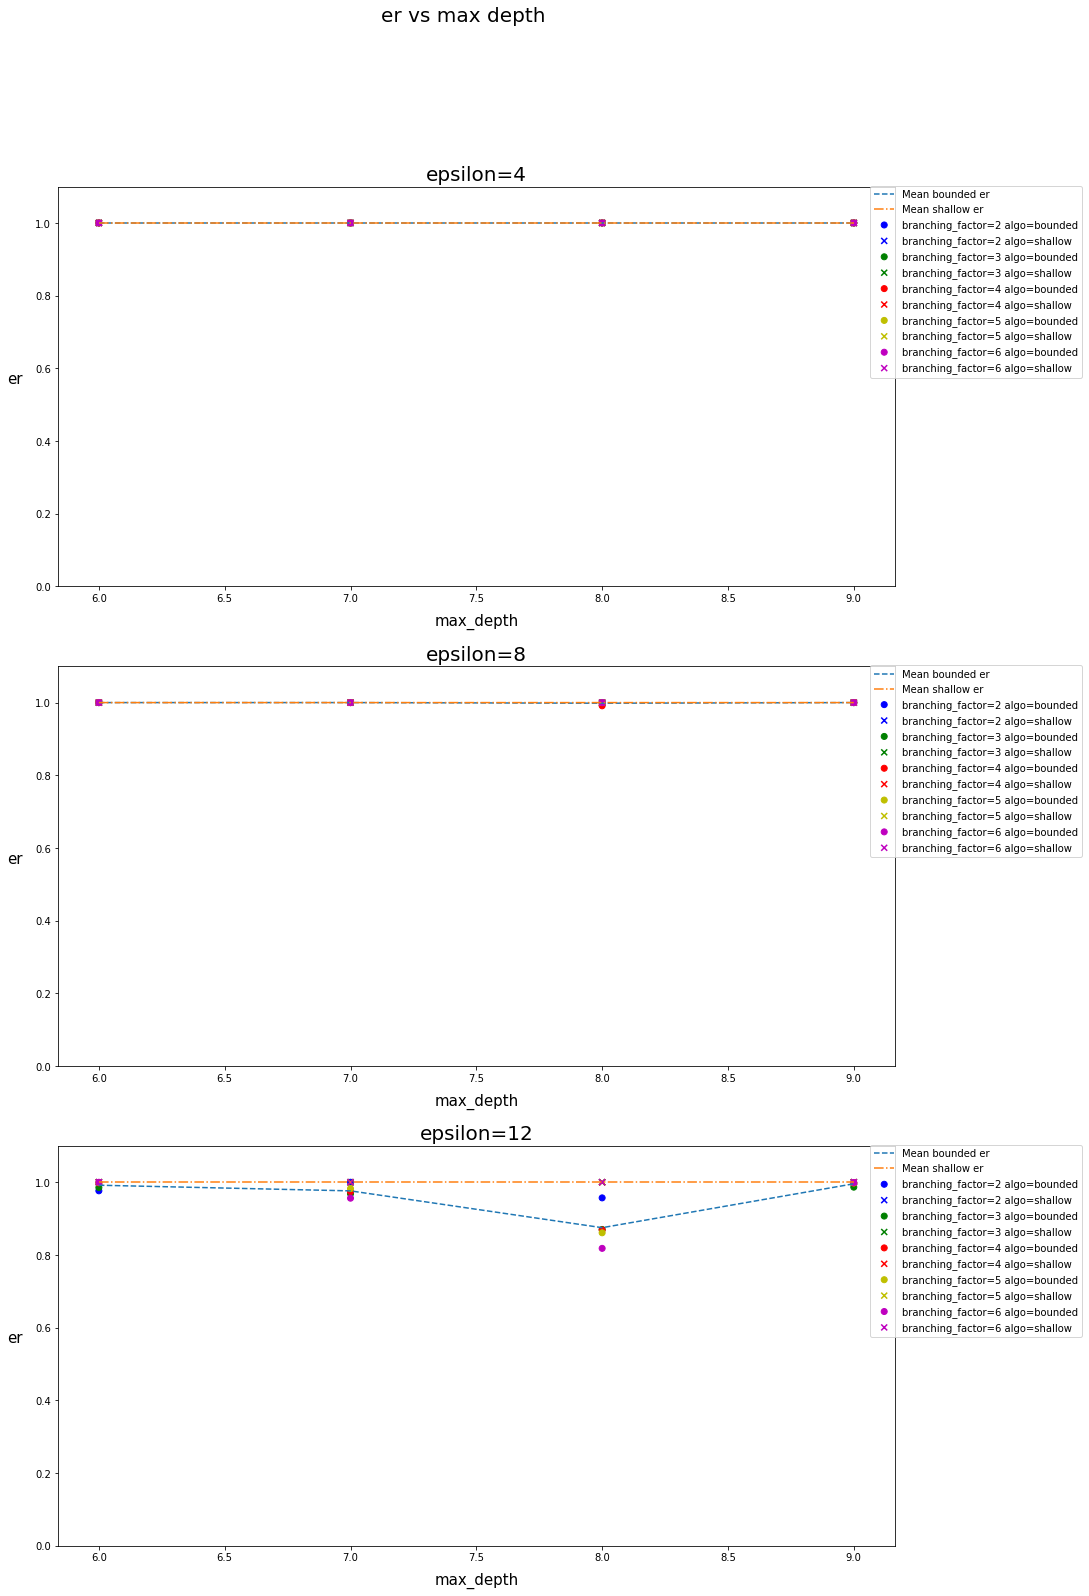

In [131]:
plot_scatter2(output_df,output_df['epsilon'].unique())